In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [18]:
df_count = pd.read_csv("results/mobilenet/count.csv")
df_original = pd.read_csv("results/mobilenet/original.csv")
df_diff = pd.read_csv("results/mobilenet/diff.csv")

In [19]:
# fazendo a média por execução (cada época aparece num_execucoes)
df_count = df_count.groupby("epoch").mean()
df_original = df_original.groupby("epoch").mean()
df_diff = df_diff.groupby("epoch").mean()

In [20]:
# splitting training and test
df_count_train = df_count[df_count.index != -1]
df_count_test = df_count[df_count.index == -1]
df_original_train = df_original[df_original.index != -1]
df_original_test = df_original[df_original.index == -1]
df_diff_train = df_diff[df_diff.index != -1]
df_diff_test = df_diff[df_diff.index == -1]

## Frequência da ReLU

In [21]:
df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]

/tmp/ipykernel_8735/2529414924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]


In [22]:
from model_utils import create_mobile_net
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parâmetros: {count_parameters(create_mobile_net(nn.ReLU(), nn.Hardswish(), nn.Hardsigmoid(), 10, pre_trained=True, freeze=False)):_}")

Número de parâmetros: 1_528_106


In [23]:
relu_proportion = df_count_train["zero_relu_call"].sum() / df_count_train["total_relu_call"].sum()
print(f"Proporção Média da ReLU: {relu_proportion}    1/{round(1/relu_proportion):_}")
print(f"Total de Ponto Não Diff: {round(df_count_train['zero_relu_call'].sum()):_} / {round(df_count_train['total_relu_call'].sum()):_}")

Proporção Média da ReLU: 4.6436646363971944e-08    1/21_534_716
Total de Ponto Não Diff: 1_610 / 34_675_200_000


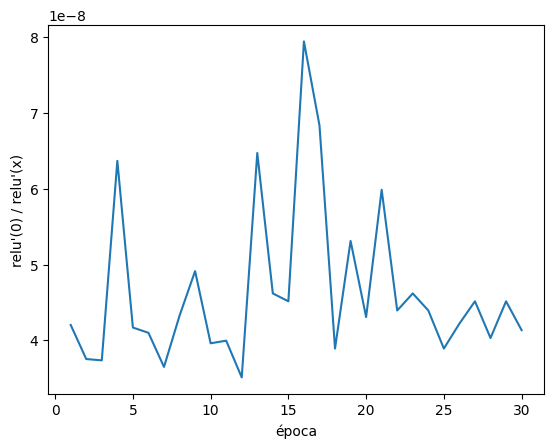

In [24]:
ax = sns.lineplot(data=df_count_train, x="epoch", y="relu_proportion")
ax.set(xlabel="época", ylabel="relu'(0) / relu'(x)")
plt.savefig('relu_proportion.eps', format='eps')

## Comparando com funções diferenciáveis

[Text(0.5, 0, 'época'), Text(0, 0.5, 'tempo (seg)')]

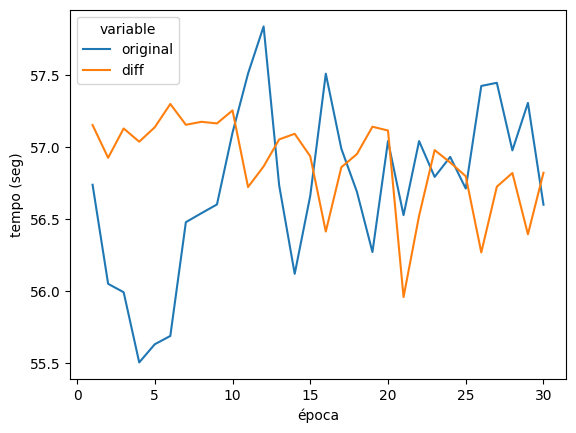

In [25]:
temp = pd.DataFrame()
temp["original"] = df_original_train["time"]
temp["diff"] = df_diff_train["time"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
#ax.set_title("Tempo por Epoca")
ax.set(xlabel="época", ylabel="tempo (seg)")

Text(0.5, 1.0, 'Loss (Treino) por Epoca')

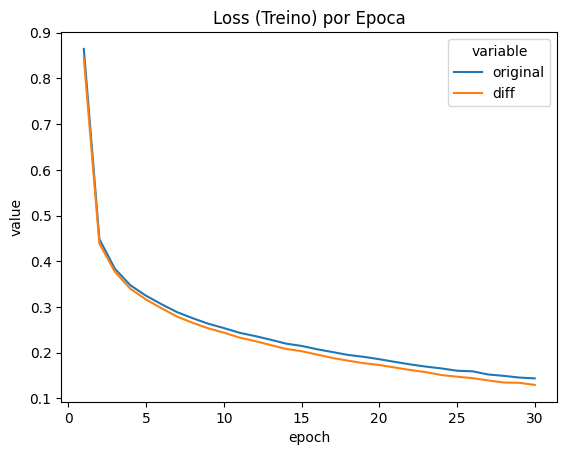

In [26]:
temp = pd.DataFrame()
temp["original"] = df_original_train["train_loss"]
temp["diff"] = df_diff_train["train_loss"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
ax.set_title("Loss (Treino) por Epoca")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


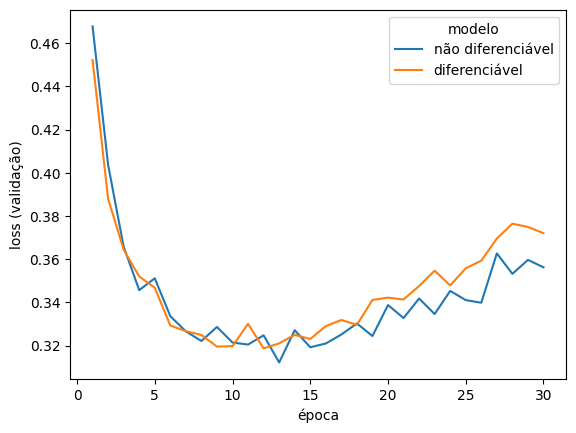

In [27]:
temp = pd.DataFrame()
temp["original"] = df_original_train["val_loss"]
temp["diff"] = df_diff_train["val_loss"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
temp = temp.rename(columns={"variable": "modelo"})
temp["modelo"] = temp["modelo"].replace("original", "não diferenciável")
temp["modelo"] = temp["modelo"].replace("diff", "diferenciável")
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="modelo")
ax.set(xlabel="época", ylabel="loss (validação)")
plt.savefig('val_loss.eps', format='eps')

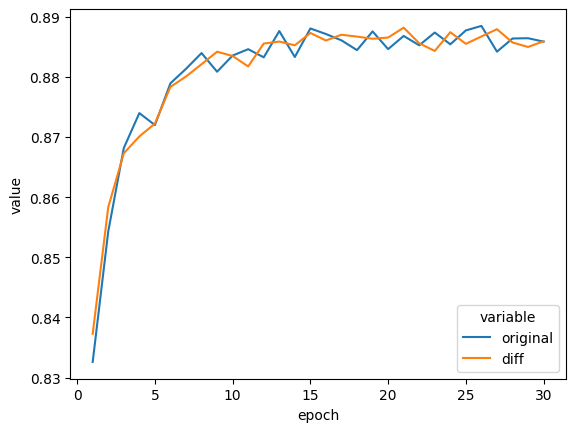

In [28]:
temp = pd.DataFrame()
temp["original"] = df_original_train["val_acc"]
temp["diff"] = df_diff_train["val_acc"]
temp["epoch"] = df_original_train.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")

In [29]:
best_original = df_original_train[df_original_train["val_loss"] == df_original_train["val_loss"].min()]
best_diff = df_diff_train[df_diff_train["val_loss"] == df_diff_train["val_loss"].min()]

linhas = ["best_epoch", "train_loss", "val_loss", "val_acc", "avg_train_time", "test_time"]

data_original = [best_original.index[0]]
data_original.extend(list(best_original.values[0])[1:4])
data_original.append(df_original_train["time"].mean())
data_original.append(df_original_test["time"].mean())
data_original

data_diff = [best_diff.index[0]]
data_diff.extend(list(best_diff.values[0])[1:4])
data_diff.append(df_diff_train["time"].mean())
data_diff.append(df_diff_test["time"].mean())

data = {"não diff": data_original, "diff": data_diff}

df = pd.DataFrame(data=data, index=linhas)
df["diferença"] = 100 * (df["diff"] - df["não diff"]) / df["não diff"]
df

,não diff,diff,diferença
best_epoch,13.000000,12.000000,-7.692308
train_loss,0.228486,0.225415,-1.344006
val_loss,0.312223,0.318697,2.073568
val_acc,0.887600,0.885522,-0.234089
avg_train_time,56.715179,56.892089,0.311927
test_time,2.110534,2.096163,-0.680916
